# Análisis de explicabilidad (XAI) por dataset – ResNet-18

En este notebook se analizan las explicaciones generadas por distintos métodos XAI
(Grad-CAM, Grad-CAM++, Integrated Gradients y Saliency) aplicados a **tres modelos
ResNet-18 independientes**:

- `blood`  → modelo entrenado solo con BloodMNIST (8 clases).
- `retina` → modelo entrenado solo con RetinaMNIST (5 clases).
- `breast` → modelo entrenado solo con BreastMNIST (2 clases).

Las explicaciones no se calculan aquí, sino que se han generado previamente desde
terminal ejecutando el script:

```bash
python xai_explanations.py --model_path results/best_model_blood.pth  --dataset blood  ...
python xai_explanations.py --model_path results/best_model_retina.pth --dataset retina ...
python xai_explanations.py --model_path results/best_model_breast.pth --dataset breast ...


In [1]:
# Configuración y rutas

from pathlib import Path
import pandas as pd
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import sys


# Ruta del proyecto
PROJECT_DIR = Path("/home/TFM_Laura_Monne").resolve()
RESULTS_DIR = PROJECT_DIR / "results"
OUTPUTS_DIR = PROJECT_DIR / "outputs"

print("Proyecto :", PROJECT_DIR)
print("Resultados:", RESULTS_DIR)
print("Outputs   :", OUTPUTS_DIR)

assert RESULTS_DIR.exists(), "❌ Falta la carpeta results/ (entrena primero con train.py)"
assert OUTPUTS_DIR.exists(), "❌ Falta la carpeta outputs/ (ejecuta primero python xai_explanations.py)"

# Aseguramos que los módulos locales (prepare_data, data_utils, resnet18) se puedan importar
if str(PROJECT_DIR) not in sys.path:
    sys.path.append(str(PROJECT_DIR))

Proyecto : /home/TFM_Laura_Monne
Resultados: /home/TFM_Laura_Monne/results
Outputs   : /home/TFM_Laura_Monne/outputs


In [2]:
# Carga de las explicaciones XAI por dataset

import json

explanations_by_dataset = {
    "blood":  json.load(open(PROJECT_DIR / "outputs/explanations_results_blood.json")),
    "retina": json.load(open(PROJECT_DIR / "outputs/explanations_results_retina.json")),
    "breast": json.load(open(PROJECT_DIR / "outputs/explanations_results_breast.json")),
}

len(explanations_by_dataset["blood"]), len(explanations_by_dataset["retina"]), len(explanations_by_dataset["breast"])

(500, 400, 156)

In [3]:
"""
En esta celda resumimos, para cada dataset (blood, retina, breast):

- nº de muestras explicadas (entradas en su JSON)
- nº de predicciones correctas (true_class == pred_class)
- accuracy (%) dentro de las muestras explicadas
"""

rows = []

for ds_name, exps in explanations_by_dataset.items():
    n = len(exps)
    correct = sum(1 for obj in exps if obj["true_class"] == obj["pred_class"])
    acc = (correct / n * 100) if n > 0 else float("nan")

    rows.append({
        "Dataset": ds_name.upper(),
        "Muestras explicadas": n,
        "Predicciones correctas": correct,
        "Accuracy dentro de las explicaciones (%)": round(acc, 2),
    })

df_xai_summary = pd.DataFrame(rows)
print("Resumen de explicaciones por dataset:")
display(df_xai_summary)


Resumen de explicaciones por dataset:


,Dataset,Muestras explicadas,Predicciones correctas,Accuracy dentro de las explicaciones (%)
0,BLOOD,500,494,98.80
1,RETINA,400,239,59.75
2,BREAST,156,140,89.74


In [4]:
import random

def choose_example(bucket: str, correct: bool = True):
    """
    Devuelve una muestra, siempre la misma, del dataset 'bucket' (blood/retina/breast)
    con predicción correcta o incorrecta según 'correct'.
    """
    exps = explanations_by_dataset[bucket]
    candidates = []
    for obj in exps:
        is_correct = (obj["true_class"] == obj["pred_class"])
        if is_correct == correct:
            candidates.append(obj)

    if not candidates:
        return None

    # Determinista: siempre el mismo ejemplo
    return candidates[0]


def show_explanations(example):
    """
    Muestra los mapas XAI (Grad-CAM, Grad-CAM++, IG, Saliency)
    de una entrada del JSON.
    """
    if example is None:
        print("⚠️ No hay ejemplo disponible con ese criterio.")
        return

    bucket = example.get("bucket", "desconocido")
    y_true = example["true_class"]
    y_pred = example["pred_class"]
    methods = example["methods"]

    print(f"Dataset (bucket): {bucket}")
    print(f"Clase real      : {y_true}")
    print(f"Clase predicha  : {y_pred}")
    print("Métodos XAI disponibles:", list(methods.keys()))

    n_methods = len(methods)
    plt.figure(figsize=(4 * n_methods, 4))

    for i, (name, info) in enumerate(methods.items()):
        path_rel = info.get("path")  # p.ej.: 'outputs/blood/gradcam/img_0_class_3.png'
        img_path = PROJECT_DIR / path_rel

        plt.subplot(1, n_methods, i + 1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis("off")
        plt.title(name.upper())

    plt.tight_layout()
    plt.show()

In [5]:
# Elegimos y guardamos SIEMPRE los mismos ejemplos
ex_blood_ok   = choose_example(bucket="blood",  correct=True)
ex_retina_ok  = choose_example(bucket="retina", correct=True)
ex_breast_ok  = choose_example(bucket="breast", correct=True)

ex_blood_bad   = choose_example(bucket="blood",  correct=False)
ex_retina_bad  = choose_example(bucket="retina", correct=False)
ex_breast_bad  = choose_example(bucket="breast", correct=False)

print("Ejemplo BLOOD correcto :", ex_blood_ok["true_class"], "->", ex_blood_ok["pred_class"])
print("Ejemplo RETINA correcto:", ex_retina_ok["true_class"], "->", ex_retina_ok["pred_class"])
print("Ejemplo BREAST correcto:", ex_breast_ok["true_class"], "->", ex_breast_ok["pred_class"])
print("Ejemplo BLOOD incorrecto :", ex_blood_bad["true_class"], "->", ex_blood_bad["pred_class"])
print("Ejemplo RETINA incorrecto:", ex_retina_bad["true_class"], "->", ex_retina_bad["pred_class"])
print("Ejemplo BREAST incorrecto:", ex_breast_bad["true_class"], "->", ex_breast_bad["pred_class"])

Ejemplo BLOOD correcto : 3 -> 3
Ejemplo RETINA correcto: 1 -> 1
Ejemplo BREAST correcto: 1 -> 1
Ejemplo BLOOD incorrecto : 6 -> 3
Ejemplo RETINA incorrecto: 2 -> 0
Ejemplo BREAST incorrecto: 0 -> 1


=== BLOOD (correcto) ===
Dataset (bucket): blood
Clase real      : 3
Clase predicha  : 3
Métodos XAI disponibles: ['gradcam', 'gradcampp', 'integrated_gradients', 'saliency']


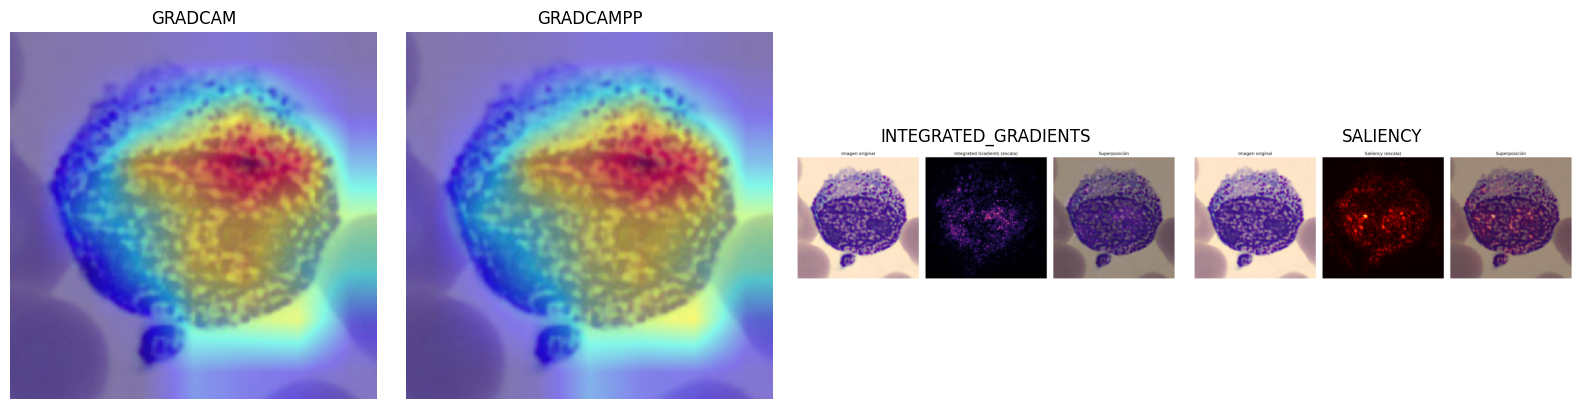


=== RETINA (correcto) ===
Dataset (bucket): retina
Clase real      : 1
Clase predicha  : 1
Métodos XAI disponibles: ['gradcam', 'gradcampp', 'integrated_gradients', 'saliency']


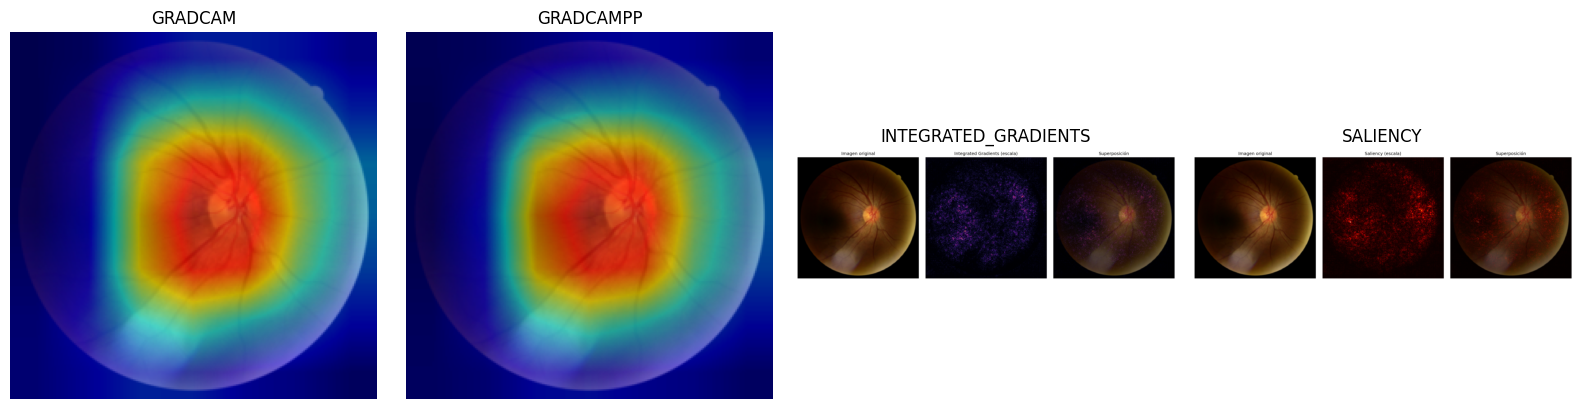


=== BREAST (correcto) ===
Dataset (bucket): breast
Clase real      : 1
Clase predicha  : 1
Métodos XAI disponibles: ['gradcam', 'gradcampp', 'integrated_gradients', 'saliency']


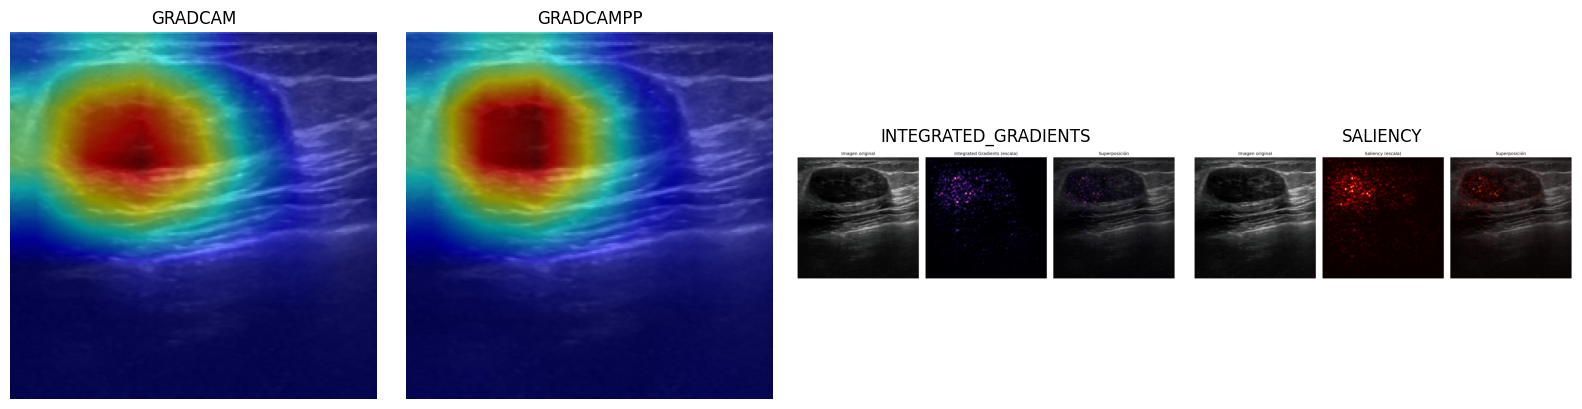


=== BLOOD (incorrecto) ===
Dataset (bucket): blood
Clase real      : 6
Clase predicha  : 3
Métodos XAI disponibles: ['gradcam', 'gradcampp', 'integrated_gradients', 'saliency']


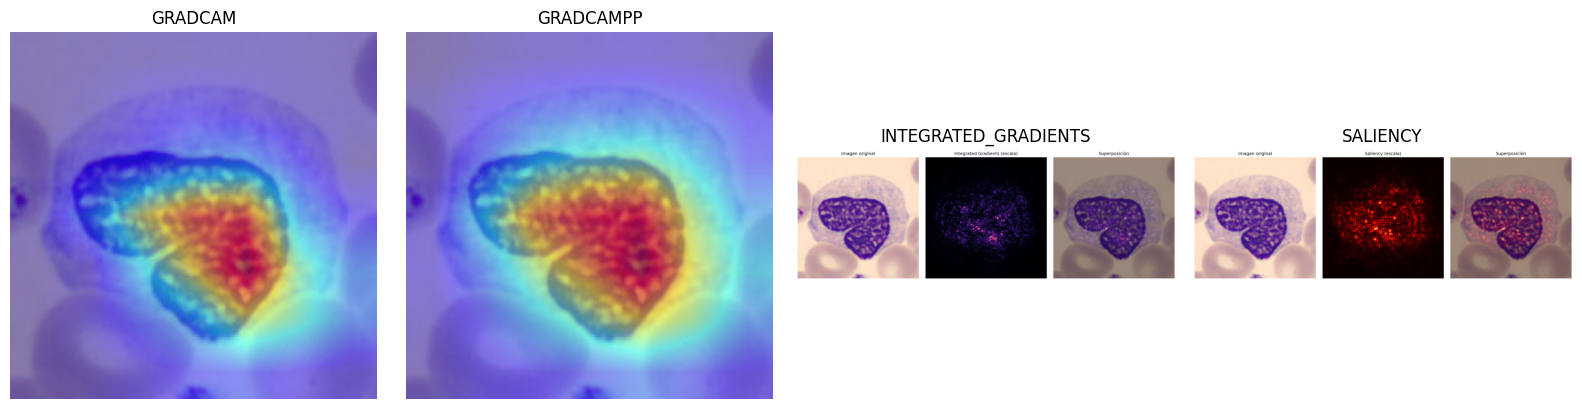


=== RETINA (incorrecto) ===
Dataset (bucket): retina
Clase real      : 2
Clase predicha  : 0
Métodos XAI disponibles: ['gradcam', 'gradcampp', 'integrated_gradients', 'saliency']


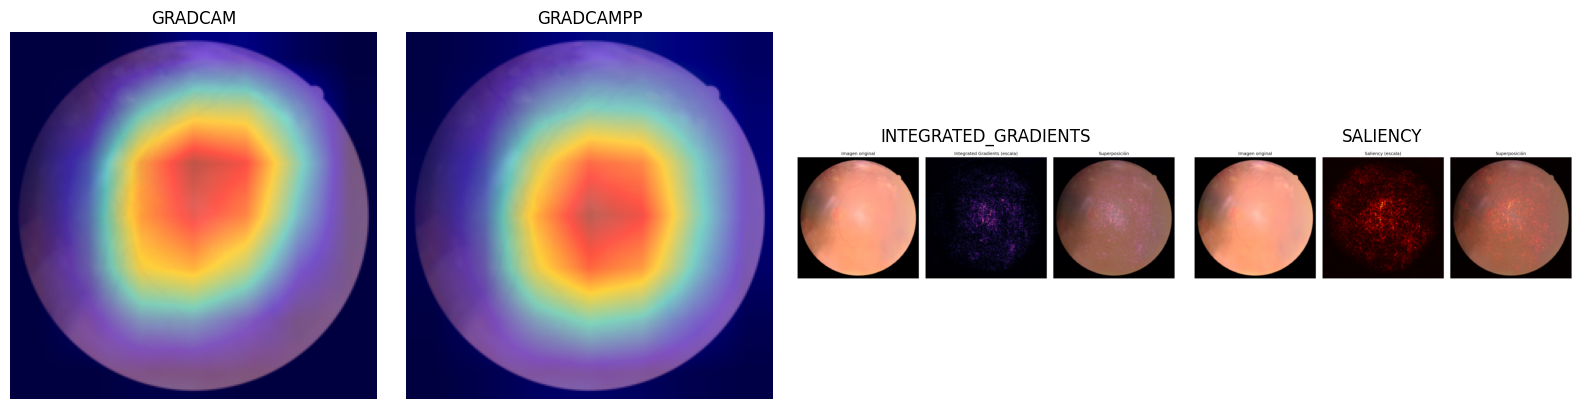


=== BREAST (incorrecto) ===
Dataset (bucket): breast
Clase real      : 0
Clase predicha  : 1
Métodos XAI disponibles: ['gradcam', 'gradcampp', 'integrated_gradients', 'saliency']


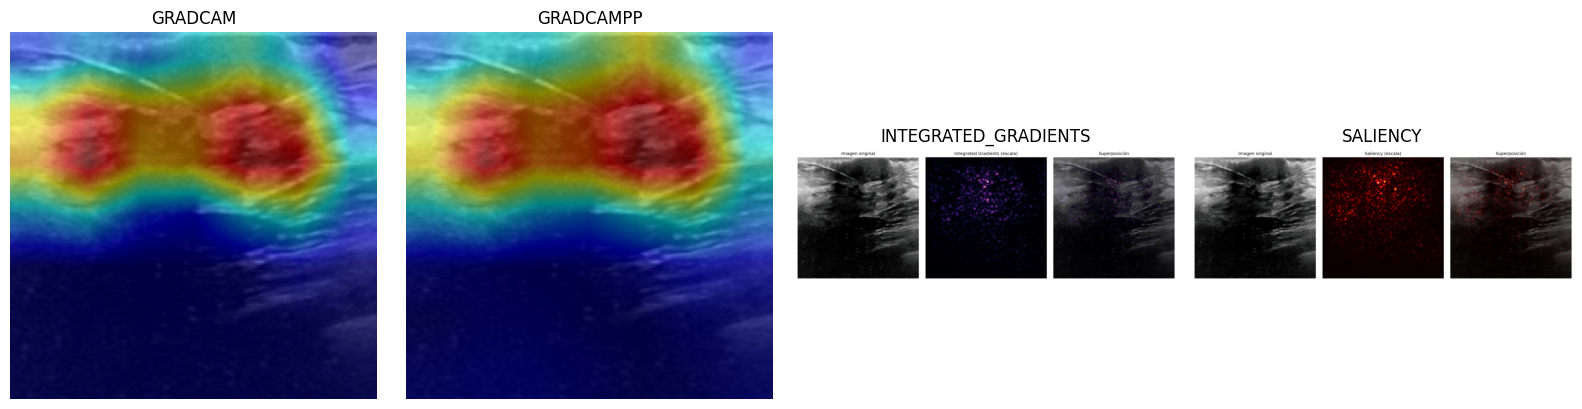

In [6]:
print("=== BLOOD (correcto) ===")
show_explanations(ex_blood_ok)

print("\n=== RETINA (correcto) ===")
show_explanations(ex_retina_ok)

print("\n=== BREAST (correcto) ===")
show_explanations(ex_breast_ok)

print("\n=== BLOOD (incorrecto) ===")
show_explanations(ex_blood_bad)

print("\n=== RETINA (incorrecto) ===")
show_explanations(ex_retina_bad)

print("\n=== BREAST (incorrecto) ===")
show_explanations(ex_breast_bad)


In [7]:
def print_example_paths(name, example):
    print(f"\n{name}:")
    for m, info in example["methods"].items():
        print(f"  {m:20s} → {info['path']}")

print_example_paths("BLOOD correcto",   ex_blood_ok)
print_example_paths("RETINA correcto",  ex_retina_ok)
print_example_paths("BREAST correcto",  ex_breast_ok)
print_example_paths("BLOOD incorrecto", ex_blood_bad)
print_example_paths("RETINA incorrecto",ex_retina_bad)
print_example_paths("BREAST incorrecto",ex_breast_bad)


BLOOD correcto:
  gradcam              → outputs/blood/gradcam/img_0_class_3.png
  gradcampp            → outputs/blood/gradcampp/img_0_class_3.png
  integrated_gradients → outputs/blood/integrated_gradients/img_0_class_3.png
  saliency             → outputs/blood/saliency/img_0_class_3.png

RETINA correcto:
  gradcam              → outputs/retina/gradcam/img_1_class_1.png
  gradcampp            → outputs/retina/gradcampp/img_1_class_1.png
  integrated_gradients → outputs/retina/integrated_gradients/img_1_class_1.png
  saliency             → outputs/retina/saliency/img_1_class_1.png

BREAST correcto:
  gradcam              → outputs/breast/gradcam/img_1_class_1.png
  gradcampp            → outputs/breast/gradcampp/img_1_class_1.png
  integrated_gradients → outputs/breast/integrated_gradients/img_1_class_1.png
  saliency             → outputs/breast/saliency/img_1_class_1.png

BLOOD incorrecto:
  gradcam              → outputs/blood/gradcam/img_35_class_3.png
  gradcampp            → o